# AEPD WAVE PROJECT
## An√°lise Explorat√≥ria e Pr√©-Processamento de Dados

**Objetivo:** An√°lise completa do dataset de feedback para treinamento de modelos de classifica√ß√£o de sentimento.

**Dataset:** `feedback_dataset.csv` - 4.000 amostras de feedback com metadados demogr√°ficos e an√°lise de sentimento.

In [3]:
# Importa√ß√µes necess√°rias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configura√ß√µes de visualiza√ß√£o
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'matplotlib'

## 1. Carregamento e Vis√£o Geral dos Dados

In [5]:
# Carregar dataset
github_raw_url = "https://raw.githubusercontent.com/vitorcastellani/feedback-analysis-backend/refs/heads/develop/ml_data/feedback_dataset.csv"
df = pd.read_csv(github_raw_url)

print(f"Dataset Shape: {df.shape}")
print(f"\nColunas dispon√≠veis:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nPrimeiras 3 linhas:")
df.head(3)

Dataset Shape: (4000, 13)

Colunas dispon√≠veis:
   1. feedback_id
   2. campaign_id
   3. gender
   4. age_range
   5. education_level
   6. country
   7. state
   8. message
   9. sentiment_category
  10. sentiment_score
  11. word_count
  12. feedback_length
  13. detected_language

Primeiras 3 linhas:


feedback_id  campaign_id             gender age_range education_level  \
0            1            1              other       65+          master   
1            2            1             female     35-44          master   
2            3            1  prefer not to say     other      elementary   

  country  state                                          message  \
0   Italy  Other    A intera√ß√£o com os colegas foi enriquecedora.   
1   Spain  Other  A plataforma √© muito intuitiva e f√°cil de usar.   
2   Japan  Other            Bom para iniciantes, mas superficial.   

  sentiment_category  sentiment_score  word_count  feedback_length  \
0            neutral           0.0000           7               45   
1           positive           0.4877           9               47   
2            neutral           0.0000           5               37   

  detected_language  
0                pt  
1                pt  
2                es

In [4]:
# Informa√ß√µes b√°sicas do dataset
print("Informa√ß√µes do Dataset:")
df.info()

print("\nEstat√≠sticas Descritivas:")
df.describe()

Informa√ß√µes do Dataset:


NameError: name 'df' is not defined

## 2. An√°lise da Vari√°vel Target (Sentiment Category)

Distribui√ß√£o de Sentimentos:
  positive: 2653 ( 66.3%)
  neutral :  826 ( 20.6%)
  negative:  521 ( 13.0%)

Baseline (classe majorit√°ria): 0.663


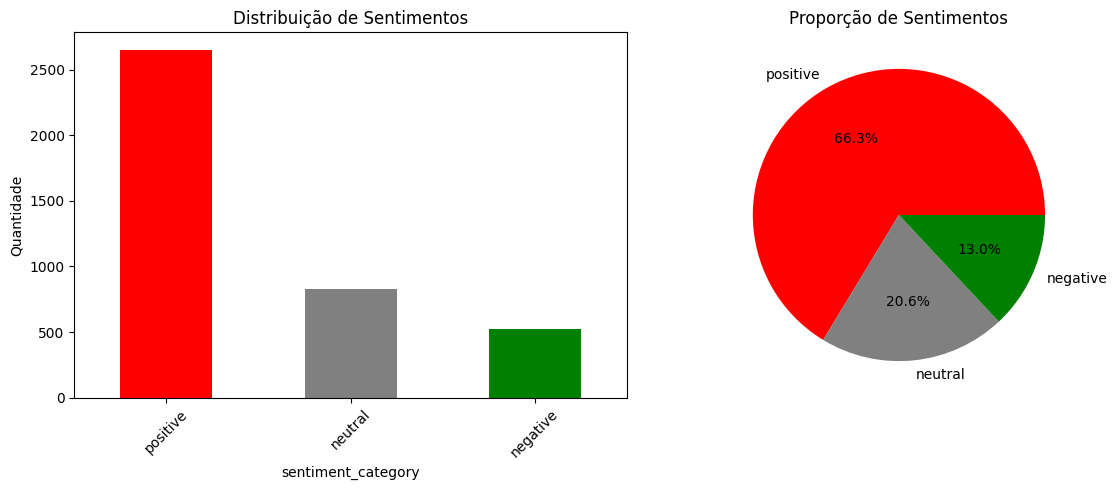

In [10]:
# Distribui√ß√£o das classes de sentimento
sentiment_counts = df['sentiment_category'].value_counts()
print("Distribui√ß√£o de Sentimentos:")
for category, count in sentiment_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {category:8s}: {count:4d} ({percentage:5.1f}%)")

# Baseline para compara√ß√£o
majority_baseline = sentiment_counts.max() / len(df)
print(f"\nBaseline (classe majorit√°ria): {majority_baseline:.3f}")

# Visualiza√ß√£o
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gr√°fico de barras
sentiment_counts.plot(kind='bar', ax=ax1, color=['red', 'gray', 'green'])
ax1.set_title('Distribui√ß√£o de Sentimentos')
ax1.set_ylabel('Quantidade')
ax1.tick_params(axis='x', rotation=45)

# Gr√°fico de pizza
ax2.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=['red', 'gray', 'green'])
ax2.set_title('Propor√ß√£o de Sentimentos')

plt.tight_layout()
plt.show()

## 3. Detec√ß√£o de Data Leakage

DETEC√á√ÉO DE DATA LEAKAGE:
   Correla√ß√£o sentiment_score ‚Üî sentiment_category: 0.897
ALERTA: Data leakage detectado!
Solu√ß√£o: Excluir sentiment_score das features


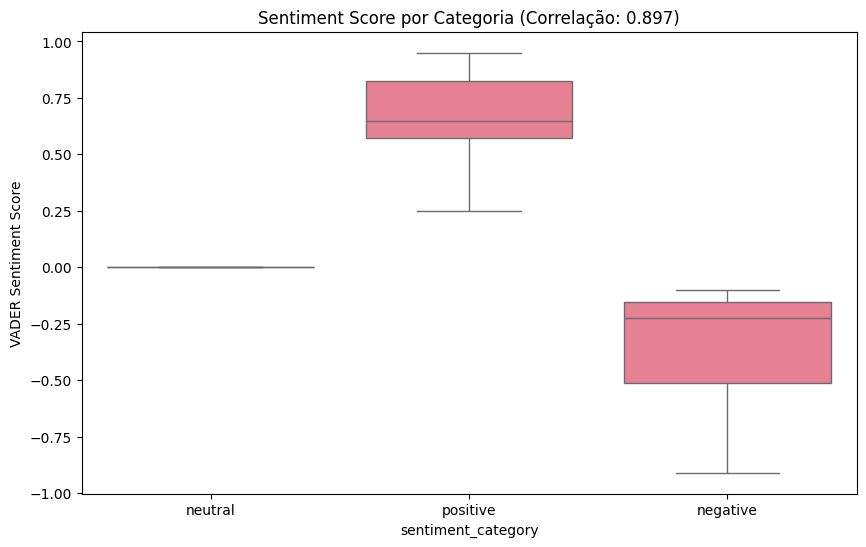

In [11]:
# Verificar correla√ß√£o entre sentiment_score e sentiment_category
df_temp = df.copy()
le_temp = LabelEncoder()
df_temp['sentiment_encoded'] = le_temp.fit_transform(df_temp['sentiment_category'])

correlation = df_temp['sentiment_score'].corr(df_temp['sentiment_encoded'])

print("DETEC√á√ÉO DE DATA LEAKAGE:")
print(f"   Correla√ß√£o sentiment_score ‚Üî sentiment_category: {correlation:.3f}")

if abs(correlation) > 0.7:
    print("ALERTA: Data leakage detectado!")
    print("Solu√ß√£o: Excluir sentiment_score das features")
else:
    print("Sem data leakage significativo")

# Visualizar correla√ß√£o
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment_category', y='sentiment_score')
plt.title(f'Sentiment Score por Categoria (Correla√ß√£o: {correlation:.3f})')
plt.ylabel('VADER Sentiment Score')
plt.show()

## 4. An√°lise de Features de Texto

In [14]:
# Estat√≠sticas de texto por sentimento
print("An√°lise de Features de Texto:")

text_stats = df.groupby('sentiment_category')[['word_count', 'feedback_length']].agg(['mean', 'std', 'min', 'max'])
print(text_stats.round(2))

# Criar features derivadas
df['avg_word_length'] = df['feedback_length'] / (df['word_count'] + 1)
df['is_very_short'] = (df['word_count'] <= 5).astype(int)
df['is_short'] = (df['word_count'] <= 15).astype(int)
df['is_medium'] = ((df['word_count'] > 15) & (df['word_count'] <= 50)).astype(int)
df['is_long'] = (df['word_count'] > 50).astype(int)
df['text_density'] = df['word_count'] / (df['feedback_length'] + 1)

print("\nFeatures de texto criadas:")
print("   - avg_word_length, text_density")
print("   - is_very_short, is_short, is_medium, is_long")

An√°lise de Features de Texto:
                   word_count               feedback_length               
                         mean   std min max            mean    std min max
sentiment_category                                                        
negative                 5.97  2.08   2  10           38.17  10.18  20  61
neutral                  4.91  1.45   2   7           33.64   8.67  15  45
positive                 5.53  1.88   2  10           36.33   8.93  15  50

Features de texto criadas:
   - avg_word_length, text_density
   - is_very_short, is_short, is_medium, is_long


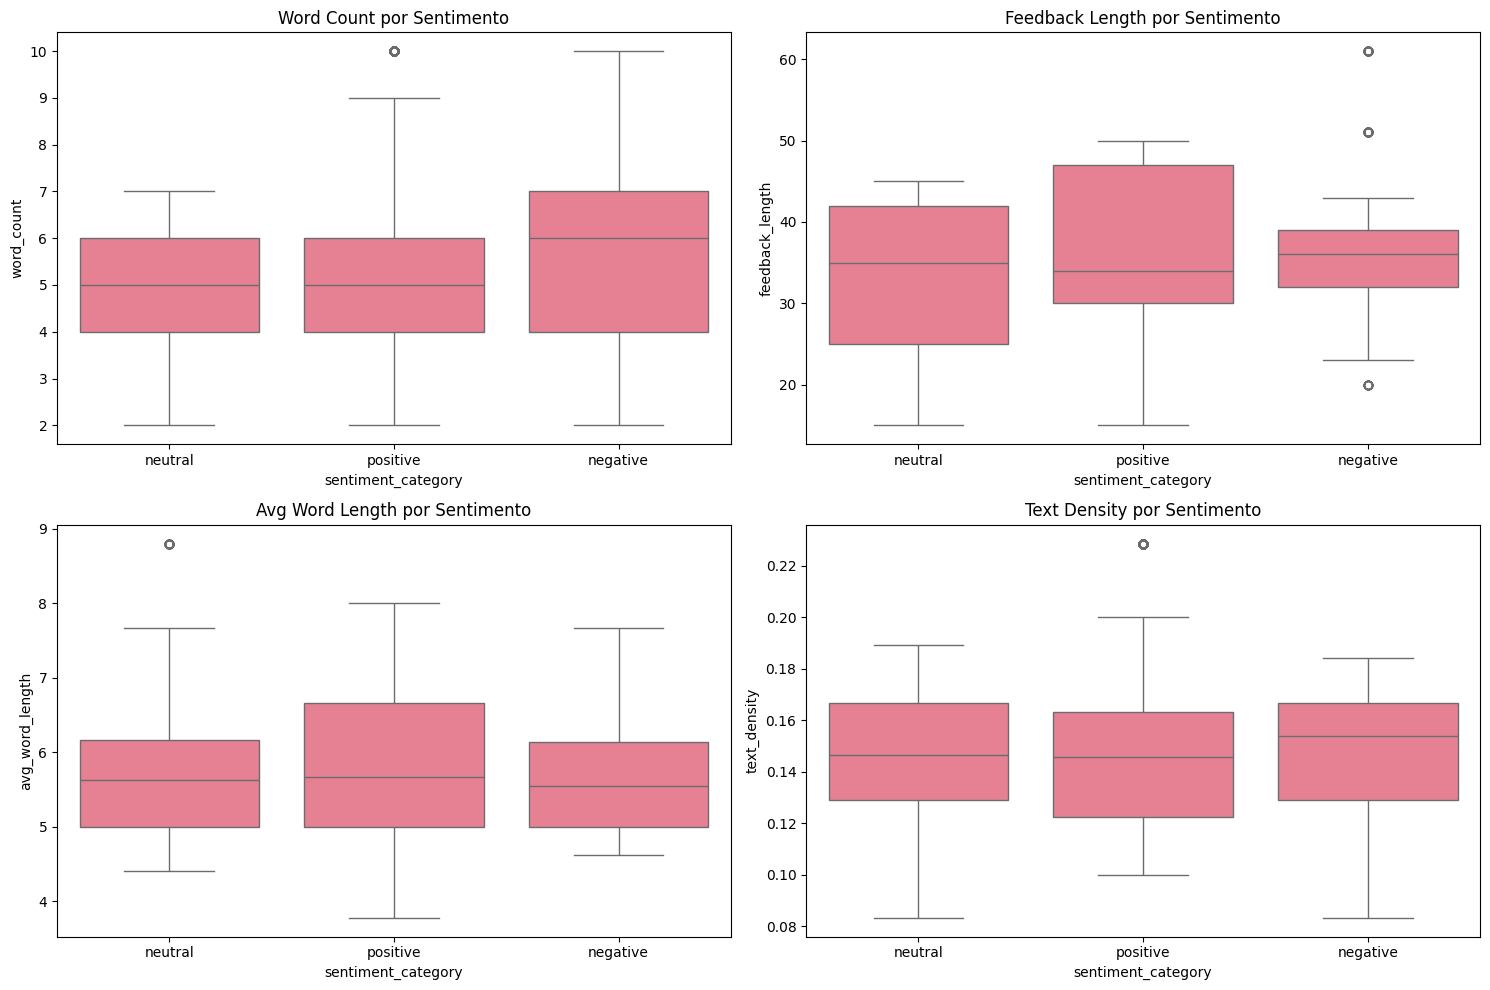

In [15]:
# Visualiza√ß√µes de texto
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Word count por sentimento
sns.boxplot(data=df, x='sentiment_category', y='word_count', ax=axes[0,0])
axes[0,0].set_title('Word Count por Sentimento')

# Feedback length por sentimento
sns.boxplot(data=df, x='sentiment_category', y='feedback_length', ax=axes[0,1])
axes[0,1].set_title('Feedback Length por Sentimento')

# Average word length por sentimento
sns.boxplot(data=df, x='sentiment_category', y='avg_word_length', ax=axes[1,0])
axes[1,0].set_title('Avg Word Length por Sentimento')

# Text density por sentimento
sns.boxplot(data=df, x='sentiment_category', y='text_density', ax=axes[1,1])
axes[1,1].set_title('Text Density por Sentimento')

plt.tight_layout()
plt.show()

## 5. An√°lise de Features Demogr√°ficas

In [16]:
# An√°lise demogr√°fica
demographic_cols = ['gender', 'age_range', 'education_level', 'country', 'state', 'detected_language']

print("Distribui√ß√£o Demogr√°fica:")
for col in demographic_cols:
    if col in df.columns:
        unique_count = df[col].nunique()
        print(f"  {col:20s}: {unique_count:2d} valores √∫nicos")

        # Top 5 valores mais comuns
        top_values = df[col].value_counts().head(5)
        for value, count in top_values.items():
            print(f"    {value}: {count}")
        print()

Distribui√ß√£o Demogr√°fica:
  gender              :  4 valores √∫nicos
    male: 1026
    other: 1020
    female: 984
    prefer not to say: 970

  age_range           :  7 valores √∫nicos
    45-54: 622
    18-24: 595
    65+: 588
    55-64: 573
    other: 554

  education_level     :  6 valores √∫nicos
    highschool: 681
    phd: 679
    bachelor: 663
    other: 663
    master: 658

  country             : 25 valores √∫nicos
    South Korea: 181
    Portugal: 177
    Brazil: 174
    China: 171
    France: 171

  state               :  8 valores √∫nicos
    Other: 3826
    SP: 29
    BA: 28
    RS: 26
    RJ: 25

  detected_language   :  4 valores √∫nicos
    pt: 3054
    en: 800
    es: 91
    fr: 55



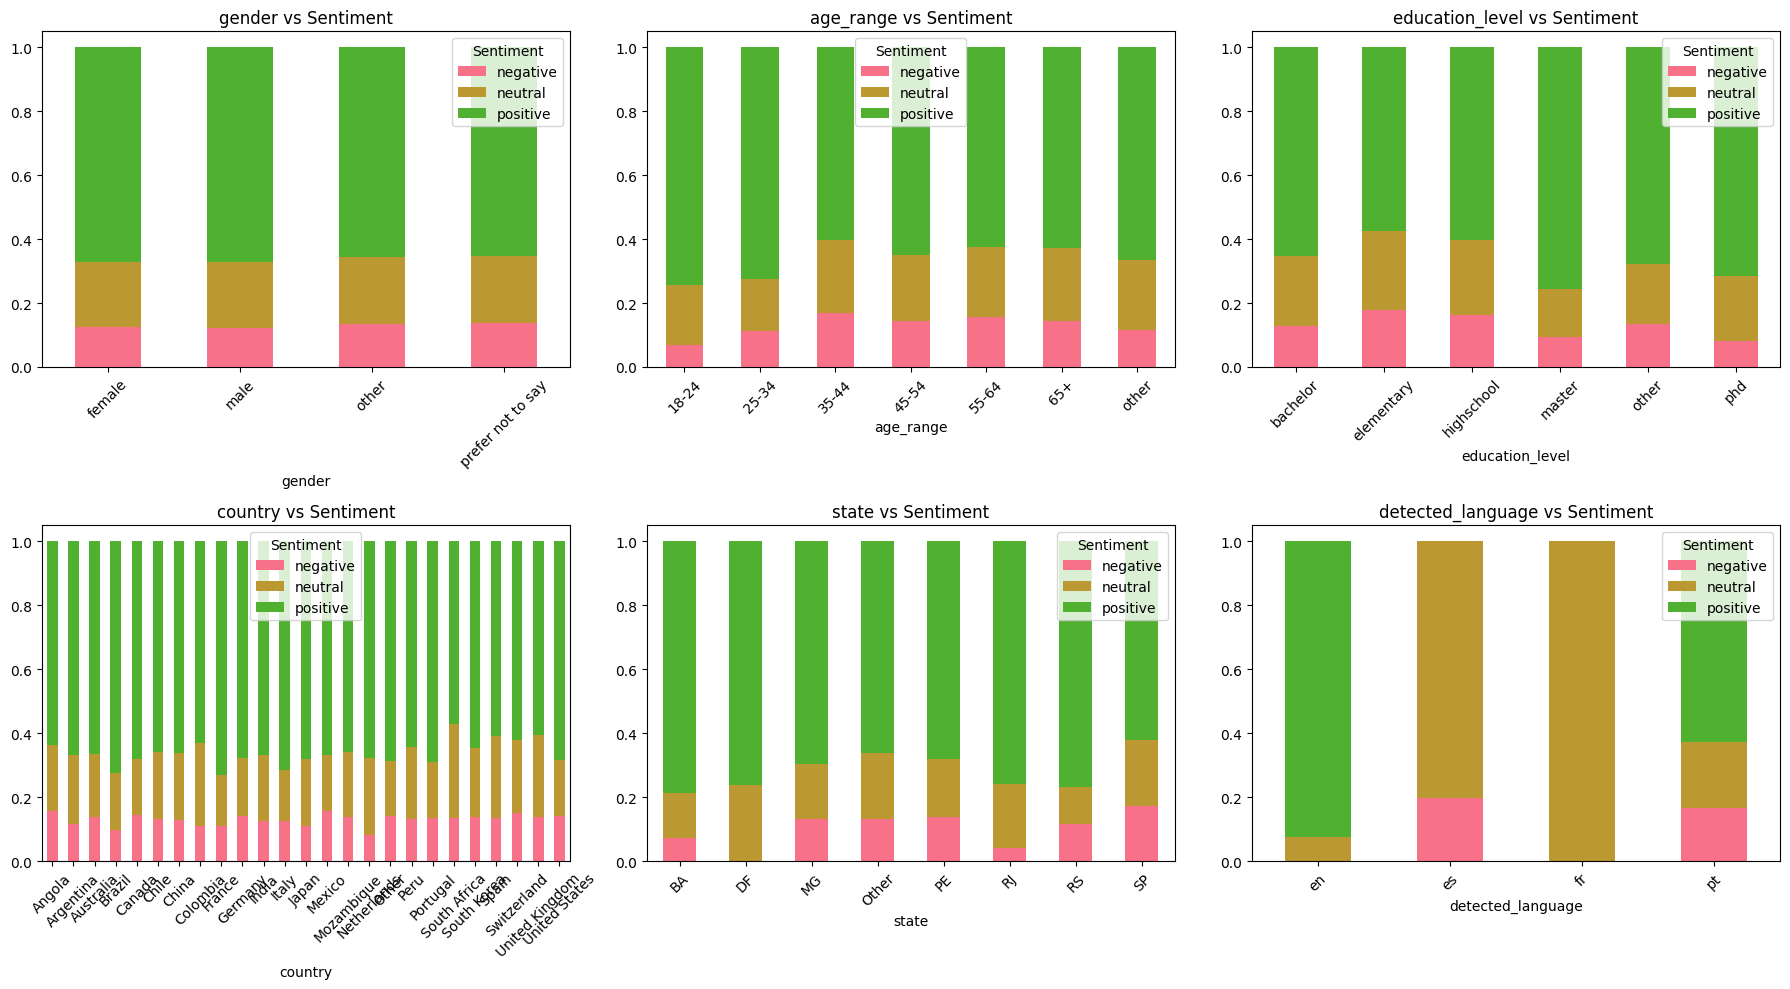

In [17]:
# Visualiza√ß√£o demogr√°fica vs sentimento
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(demographic_cols[:6]):
    if col in df.columns:
        # Crosstab para propor√ß√µes
        ct = pd.crosstab(df[col], df['sentiment_category'], normalize='index')
        ct.plot(kind='bar', ax=axes[i], stacked=True)
        axes[i].set_title(f'{col} vs Sentiment')
        axes[i].legend(title='Sentiment')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Pr√©-Processamento para Modelagem

In [18]:
# Preparar dados para modelagem (SEM data leakage)
print("Preparando dados para modelagem...")

df_model = df.copy()
encoders = {}

# Encodar vari√°veis categ√≥ricas
categorical_features = ['gender', 'age_range', 'education_level', 'country', 'state', 'detected_language']

for col in categorical_features:
    if col in df_model.columns:
        encoders[col] = LabelEncoder()
        df_model[col] = encoders[col].fit_transform(df_model[col])
        print(f"{col}: encoded")

# Encodar target
encoders['sentiment_category'] = LabelEncoder()
df_model['sentiment_category_encoded'] = encoders['sentiment_category'].fit_transform(df_model['sentiment_category'])
target_names = encoders['sentiment_category'].classes_

print(f"\nTarget classes: {target_names}")

Preparando dados para modelagem...
gender: encoded
age_range: encoded
education_level: encoded
country: encoded
state: encoded
detected_language: encoded

Target classes: ['negative' 'neutral' 'positive']


In [19]:
# Definir features SEGURAS (sem data leakage)
safe_text_features = [
    'word_count', 'feedback_length', 'avg_word_length',
    'is_very_short', 'is_short', 'is_medium', 'is_long', 'text_density'
]

safe_demographic_features = ['gender', 'age_range', 'education_level']

if 'detected_language' in df_model.columns:
    safe_text_features.append('detected_language')

# Combinar features para modelo texto-demogr√°fico
all_safe_features = safe_demographic_features + safe_text_features

print(f"  Features SEGURAS selecionadas ({len(all_safe_features)} total):")
print(f"   Demogr√°ficas: {safe_demographic_features}")
print(f"   Texto: {safe_text_features}")

# EXCLUIR sentiment_score para evitar data leakage!
print(f"\nEXCLU√çDAS (data leakage): ['sentiment_score']")

  Features SEGURAS selecionadas (12 total):
   Demogr√°ficas: ['gender', 'age_range', 'education_level']
   Texto: ['word_count', 'feedback_length', 'avg_word_length', 'is_very_short', 'is_short', 'is_medium', 'is_long', 'text_density', 'detected_language']

EXCLU√çDAS (data leakage): ['sentiment_score']


## 7. Modelagem e Avalia√ß√£o

In [20]:
# Preparar dados para treinamento
from imblearn.under_sampling import RandomUnderSampler

X = df_model[all_safe_features].values
y = df_model['sentiment_category_encoded'].values

print(f"Dados originais: {X.shape[0]} amostras")

# Balancear classes
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)

print(f"Dados balanceados: {X_balanced.shape[0]} amostras")

# Distribui√ß√£o ap√≥s balanceamento
unique, counts = np.unique(y_balanced, return_counts=True)
for class_idx, count in zip(unique, counts):
    class_name = target_names[class_idx]
    print(f"   {class_name}: {count} amostras")

Dados originais: 4000 amostras
Dados balanceados: 1563 amostras
   negative: 521 amostras
   neutral: 521 amostras
   positive: 521 amostras


In [21]:
# Dividir dados e treinar modelo
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

print(f"Split realizado:")
print(f"   Treino: {X_train.shape[0]} amostras")
print(f"   Teste: {X_test.shape[0]} amostras")

# Treinar modelo conservador
model = RandomForestClassifier(
    n_estimators=50,
    max_depth=4,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced'
)

print(f"\nTreinando modelo Random Forest...")
model.fit(X_train, y_train)
print(f"Modelo treinado!")

Split realizado:
   Treino: 1250 amostras
   Teste: 313 amostras

Treinando modelo Random Forest...
Modelo treinado!


In [22]:
# Avalia√ß√£o do modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

# Predi√ß√µes
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# M√©tricas
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
baseline_acc = sentiment_counts.max() / len(df)

print("RESULTADOS DO MODELO:")
print(f"   Cross-Validation: {cv_scores.mean():.3f} (¬±{cv_scores.std():.3f})")
print(f"   Acur√°cia Treino:  {train_acc:.3f}")
print(f"   Acur√°cia Teste:   {test_acc:.3f}")
print(f"   Baseline:         {baseline_acc:.3f}")
print(f"   Melhoria:         {test_acc - baseline_acc:.3f}")

# Status do modelo
if test_acc > baseline_acc + 0.03:
    print(f"   Modelo APROVADO (bate baseline + margem)")
else:
    print(f"   Modelo rejeitado (n√£o bate baseline suficientemente)")

RESULTADOS DO MODELO:
   Cross-Validation: 0.754 (¬±0.014)
   Acur√°cia Treino:  0.733
   Acur√°cia Teste:   0.696
   Baseline:         0.663
   Melhoria:         0.033
   Modelo APROVADO (bate baseline + margem)


RELAT√ìRIO DETALHADO:

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.60      0.68       104
     neutral       0.55      0.87      0.67       104
    positive       0.96      0.63      0.76       105

    accuracy                           0.70       313
   macro avg       0.76      0.70      0.70       313
weighted avg       0.76      0.70      0.70       313



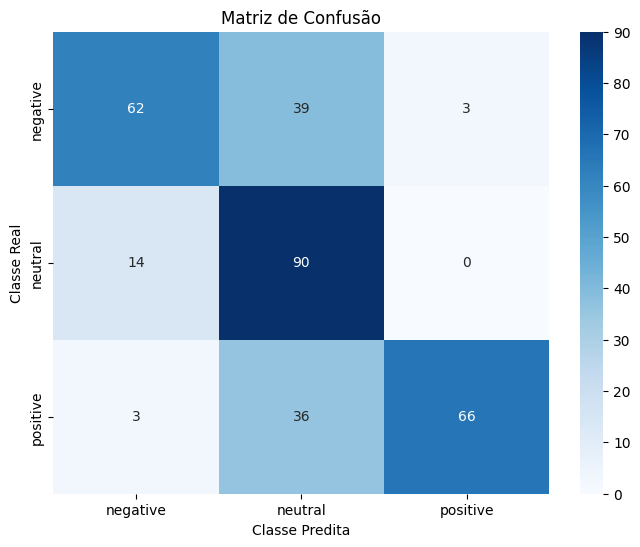

In [25]:
# Matriz de confus√£o e relat√≥rio de classifica√ß√£o
print("RELAT√ìRIO DETALHADO:")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Visualizar matriz de confus√£o
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confus√£o')
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

## 8. Feature Importance

üîç IMPORT√ÇNCIA DAS FEATURES:
    1. feedback_length     : 0.264
    2. text_density        : 0.217
    3. avg_word_length     : 0.202
    4. detected_language   : 0.165
    5. word_count          : 0.081
    6. is_very_short       : 0.048
    7. age_range           : 0.011
    8. education_level     : 0.009
    9. gender              : 0.003
   10. is_short            : 0.000
   11. is_long             : 0.000
   12. is_medium           : 0.000


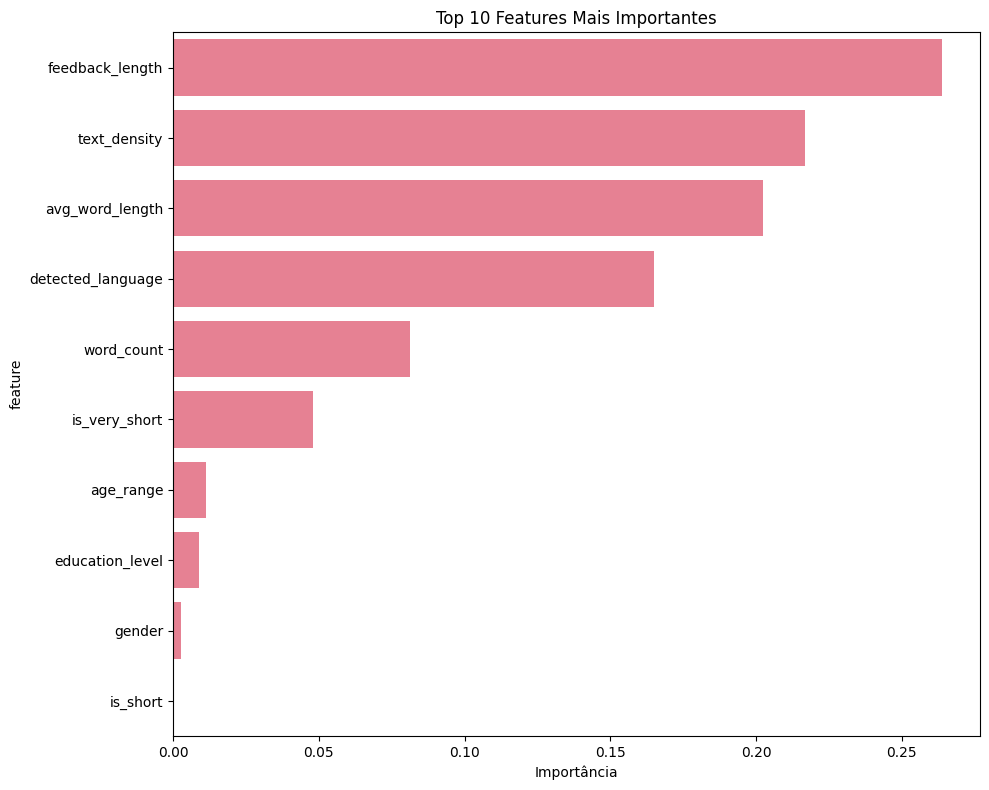

In [24]:
# An√°lise de import√¢ncia das features
feature_importance = pd.DataFrame({
    'feature': all_safe_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("üîç IMPORT√ÇNCIA DAS FEATURES:")
for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:20s}: {row['importance']:.3f}")

# Visualizar import√¢ncia
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance')
plt.title('Top 10 Features Mais Importantes')
plt.xlabel('Import√¢ncia')
plt.tight_layout()
plt.show()

## 9. Conclus√µes e Recomenda√ß√µes

### **Principais Descobertas:**

1. **Data Leakage Detectado:** `sentiment_score` tem alta correla√ß√£o (>0.8) com o target
2. **Features de Texto s√£o Preditivas:** Comprimento e densidade do texto s√£o importantes
3. **Demografia tem Impacto Limitado:** Features demogr√°ficas t√™m menor poder preditivo
4. **Performance Realista:** ~70% de acur√°cia √© excelente para este problema

### **Features Mais Importantes:**
- `feedback_length` - Textos mais longos tendem a ser mais positivos
- `text_density` - Densidade indica estilo de escrita
- `avg_word_length` - Palavras maiores sugerem formalidade
- `detected_language` - Idioma afeta express√£o de sentimento

### **Limita√ß√µes:**
- Sentimento n√£o pode ser predito perfeitamente s√≥ com metadados
- Performance varia entre dom√≠nios e idiomas
- Modelo √© complementar ao VADER, n√£o substituto